Using device: cuda

Detected objects:
✔ closet: 0.900 | box=[1789.89, 467.61, 1965.14, 1087.39]
✔ 2sdoor: 0.306 | box=[3154.16, 1254.21, 3630.25, 1445.55]
✔ closet: 0.739 | box=[173.55, 1203.59, 551.87, 1379.58]
✔ 2sdoor: 0.574 | box=[3163.54, 1258.5, 3644.59, 1478.55]
✔ 2sdoor: 0.796 | box=[3148.14, 1258.09, 3646.09, 1470.16]
✔ 1stdoor: 0.615 | box=[3172.87, 1249.55, 3415.84, 1476.36]
✔ closet: 0.902 | box=[2043.91, 404.34, 2195.07, 921.67]
✔ 1stdoor: 0.972 | box=[908.97, 2125.7, 1135.3, 2367.95]
✔ 1stdoor: 0.988 | box=[2260.08, 949.48, 2471.14, 1188.19]
✔ sink: 0.637 | box=[345.21, 1710.92, 529.1, 1897.42]
✔ sink: 0.650 | box=[746.76, 1981.47, 886.09, 2168.73]
✔ 1stdoor: 0.869 | box=[3315.64, 1261.61, 3627.99, 1482.6]
✔ sink: 0.520 | box=[527.07, 1726.54, 696.56, 1886.26]
✔ sink: 0.697 | box=[357.23, 1897.08, 548.49, 2054.22]
✔ 1stdoor: 0.965 | box=[2046.93, 961.07, 2221.69, 1171.84]


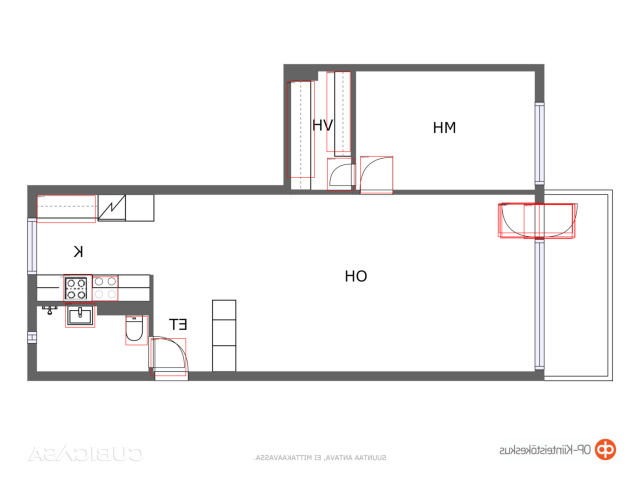

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from transformers import DetrForObjectDetection, DetrImageProcessor

# =======================
# CONFIG
# =======================

# Path to the model relative to the 'Code' folder
MODEL_DIR = r"..\Models\detr-finetuned-floorplans"

# Path to the image relative to the 'Code' folder
# I set this to a file in 'images_before' that likely exists. 
# You can change 'image_022.jpg' to any specific file you have.
IMAGE_PATH = r"..\Data\images_before\image_022.jpg"

THRESH = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# Load model + processor
# =======================
print(f"Loading model from: {MODEL_DIR}")
processor = DetrImageProcessor.from_pretrained(MODEL_DIR)
model = DetrForObjectDetection.from_pretrained(MODEL_DIR).to(device)
model.eval()

# =======================
# Load image
# =======================
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

print(f"Loading image: {IMAGE_PATH}")
image = Image.open(IMAGE_PATH).convert("RGB")

inputs = processor(images=image, return_tensors="pt").to(device)

# =======================
# Inference
# =======================
with torch.no_grad():
    outputs = model(**inputs)

# =======================
# Post-process
# =======================
target_sizes = torch.tensor([image.size[::-1]]).to(device)
results = processor.post_process_object_detection(
    outputs,
    target_sizes=target_sizes,
    threshold=THRESH
)[0]

# =======================
# Draw results
# =======================
draw = ImageDraw.Draw(image)

print("\nDetected objects:")
if len(results["scores"]) == 0:
    print("No detections above threshold")
else:
    for score, label, box in zip(
        results["scores"],
        results["labels"],
        results["boxes"]
    ):
        label_name = model.config.id2label[label.item()]
        score = score.item()
        box = [round(i, 2) for i in box.tolist()]

        print(f"Label: {label_name} | Score: {score:.3f} | Box: {box}")

        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{label_name} {score:.2f}", fill="black")

# =======================
# Show image
# =======================
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

🚀 Using device: cuda
Loading DETR...
Loading SAM...


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Found 12 objects. Generating masks...


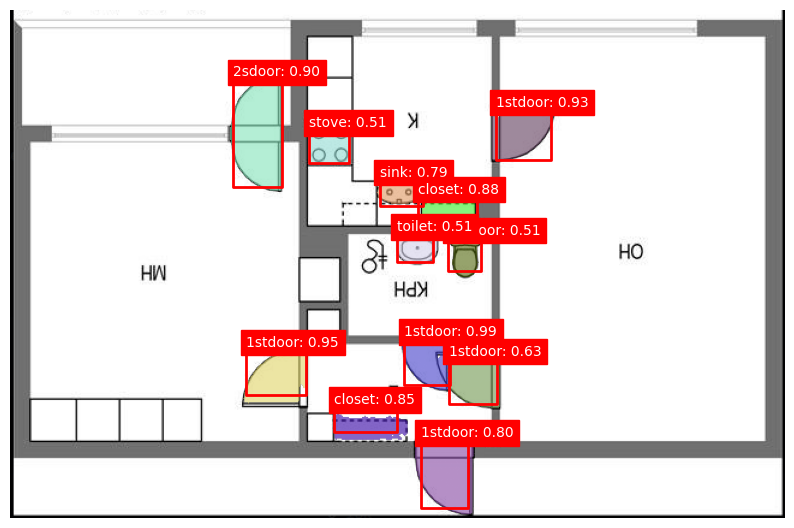

In [ ]:
import torch
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DetrImageProcessor, DetrForObjectDetection
from segment_anything import sam_model_registry, SamPredictor

# ===========================
# 1. Configuration
# ===========================

# Path to DETR model (relative to Code folder)
DETR_MODEL_PATH = r"..\Models\detr-finetuned-floorplans"

# Path to SAM checkpoint (relative to Code folder)
SAM_CHECKPOINT  = r"..\Models\Sam_Checkpoint\sam_vit_h_4b8939.pth"

# Path to Image (relative to Code folder)
# I set a default one from your Data folder, change if needed
IMAGE_PATH = r"..\Data\images_before\image_022.jpg"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ===========================
# 2. Load Models
# ===========================

# Load DETR
print("Loading DETR...")
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr_model = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE)

# Load SAM
print(f"Loading SAM from: {SAM_CHECKPOINT}")
if not os.path.exists(SAM_CHECKPOINT):
    raise FileNotFoundError(f"SAM checkpoint not found at: {SAM_CHECKPOINT}")

sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
mask_predictor = SamPredictor(sam)

# ===========================
# 3. Object Detection (DETR)
# ===========================
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

print(f"Loading image: {IMAGE_PATH}")
image_pil = Image.open(IMAGE_PATH).convert("RGB")
inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = detr_model(**inputs)

# Process results (bounding boxes)
target_sizes = torch.tensor([image_pil.size[::-1]]).to(DEVICE)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

# ===========================
# 4. Generate Masks (SAM)
# ===========================
# SAM requires a Numpy Array
image_np = np.array(image_pil)
mask_predictor.set_image(image_np)

print(f"Found {len(results['boxes'])} objects. Generating masks...")

plt.figure(figsize=(10, 10))
plt.imshow(image_pil)

# Iterate over all detected objects
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().numpy() # Convert to Numpy
    label_name = detr_model.config.id2label[label.item()]
    
    # Send the bounding box to SAM to generate the segmentation mask
    # multimask_output=False returns the single best mask
    masks, scores, logits = mask_predictor.predict(
        box=box[None, :], 
        multimask_output=False
    )
    
    # The mask is a boolean array
    mask = masks[0]
    
    # --- Visualization ---
    # Draw bounding box
    x0, y0, x1, y1 = box
    plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'r-', linewidth=2)
    plt.text(x0, y0, f"{label_name}: {score:.2f}", color='white', backgroundcolor='red')
    
    # Draw mask (semi-transparent)
    # Generate a random color with alpha (transparency)
    color = np.concatenate([np.random.random(3), [0.6]]) 
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    plt.gca().imshow(mask_image)

plt.axis('off')
plt.show()

🚀 Starting Pipeline on cuda...
1️⃣ Loading DETR for detection...
2️⃣ Loading SAM for segmentation...
🔍 Searching specifically for 'stove'...
   ⚠️ Found 'sink' (score: 0.79), but skipping...
   ⚠️ Found '1stdoor' (score: 0.96), but skipping...
   ⚠️ Found '1stdoor' (score: 0.98), but skipping...
   ⚠️ Found '1stdoor' (score: 0.98), but skipping...
   ⚠️ Found '1stdoor' (score: 0.86), but skipping...
   ⚠️ Found 'closet' (score: 0.91), but skipping...
   ⚠️ Found '1stdoor' (score: 0.97), but skipping...
   ✅ MATCH! Found 'stove' with confidence 0.57
3️⃣ Loading Stable Diffusion for Inpainting...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.82it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


🎨 Removing 'stove' and filling with floor...


100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


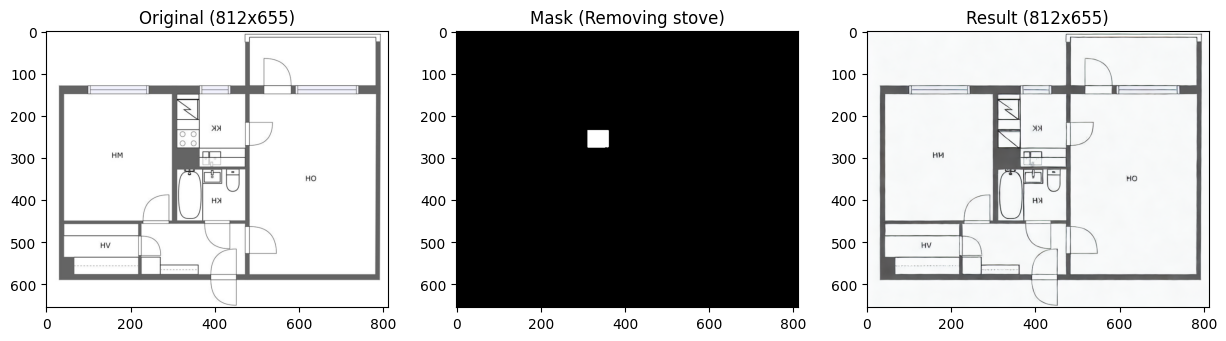

In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import gc
import os

# Hugging Face Libraries
from transformers import DetrImageProcessor, DetrForObjectDetection
from diffusers import StableDiffusionInpaintPipeline
from segment_anything import sam_model_registry, SamPredictor

# ===========================
# 1. Configuration
# ===========================

# Path to DETR model (relative to Code folder)
DETR_MODEL_PATH = r"..\Models\detr-finetuned-floorplans"

# Path to SAM checkpoint (relative to Code folder)
SAM_CHECKPOINT  = r"..\Models\Sam_Checkpoint\sam_vit_h_4b8939.pth"

# Path to Image (relative to Code folder)
# Using a default image from your Data folder
IMAGE_PATH      = r"..\Data\images_before\image_022.jpg"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_LABEL = "stove"  # The object we want to remove
PROMPT = "clean floor tiles, architectural plan background, top down view, empty space, seamless texture"
NEGATIVE_PROMPT = "stove, furniture, objects, text, distortion, appliance, sink, 3d render"

print(f"Starting Pipeline on {DEVICE}...")

# ===========================
# 2. Step A: Detection with DETR
# ===========================
print("1. Loading DETR for detection...")
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr_model = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE)
 
# --- IMPORTANT: Save the label map before deleting the model ---
id2label = detr_model.config.id2label
# -------------------------------------------------------------

if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

image_pil = Image.open(IMAGE_PATH).convert("RGB")
inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = detr_model(**inputs)

# Process results
target_sizes = torch.tensor([image_pil.size[::-1]]).to(DEVICE)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.4)[0]

# Clear DETR memory
del detr_model, processor, inputs, outputs
torch.cuda.empty_cache()
gc.collect()

# ===========================
# 3. Step B: Segmentation with SAM (including filtering)
# ===========================
print("2. Loading SAM for segmentation...")
if not os.path.exists(SAM_CHECKPOINT):
    raise FileNotFoundError(f"SAM checkpoint not found at: {SAM_CHECKPOINT}")

sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
mask_predictor = SamPredictor(sam)

image_np = np.array(image_pil)
mask_predictor.set_image(image_np)

target_mask = None
print(f"Searching specifically for '{TARGET_LABEL}'...")

# Loop to filter unwanted results
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # Check object name
    label_id = label.item()
    label_name = id2label[label_id] # Use the saved dictionary
    
    if label_name != TARGET_LABEL:
        print(f"   Found '{label_name}' (score: {score:.2f}), but skipping...")
        continue # Not what we are looking for, skip to next

    # If we are here - we found the object!
    print(f"   MATCH! Found '{label_name}' with confidence {score:.2f}")
    
    box = box.cpu().numpy()
    masks, scores_sam, _ = mask_predictor.predict(box=box[None, :], multimask_output=False)
    target_mask = masks[0]
    break # Found one, break to process it

# Clear SAM memory
del sam, mask_predictor
torch.cuda.empty_cache()
gc.collect()

if target_mask is None:
    print(f"Error: Could not find any object named '{TARGET_LABEL}' in this image.")
else:
    # ===========================
    # 4. Step C: Generation/Removal with Stable Diffusion
    # ===========================
    print("3. Loading Stable Diffusion for Inpainting...")
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        torch_dtype=torch.float16,
        variant="fp16",
        use_safetensors=True,
        safety_checker=None
    ).to(DEVICE)

    print(f"Removing '{TARGET_LABEL}' and filling with floor...")
    
    # --- Resize image (Critical!) ---
    original_width, original_height = image_pil.size
    
    # Calculate new size divisible by 8 (Model requirement)
    new_width = original_width - (original_width % 8)
    new_height = original_height - (original_height % 8)
    
    mask_image = Image.fromarray(target_mask)
    
    new_image = pipe(
        prompt=PROMPT,
        negative_prompt=NEGATIVE_PROMPT, # Prevents unwanted furniture
        image=image_pil,
        mask_image=mask_image,
        height=new_height,    # Set adjusted height
        width=new_width,      # Set adjusted width
        num_inference_steps=30,
        guidance_scale=7.5
    ).images[0]

    # Resize back to original size (if there was a slight crop)
    if new_image.size != (original_width, original_height):
        new_image = new_image.resize((original_width, original_height), Image.LANCZOS)

    # ===========================
    # 5. Display Results
    # ===========================
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"Original ({original_width}x{original_height})")
    plt.imshow(image_pil)

    plt.subplot(1, 3, 2)
    plt.title(f"Mask (Removing {TARGET_LABEL})")
    plt.imshow(target_mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title(f"Result ({original_width}x{original_height})")
    plt.imshow(new_image)
    plt.show()